✅ Loaded matrix:  36753  genes x  800  cells


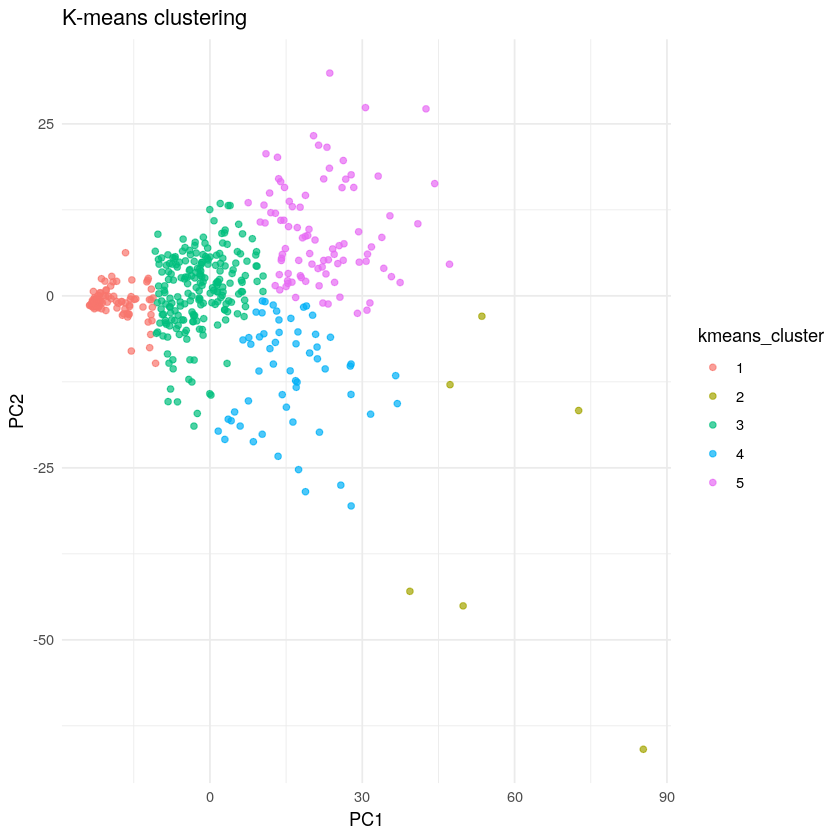

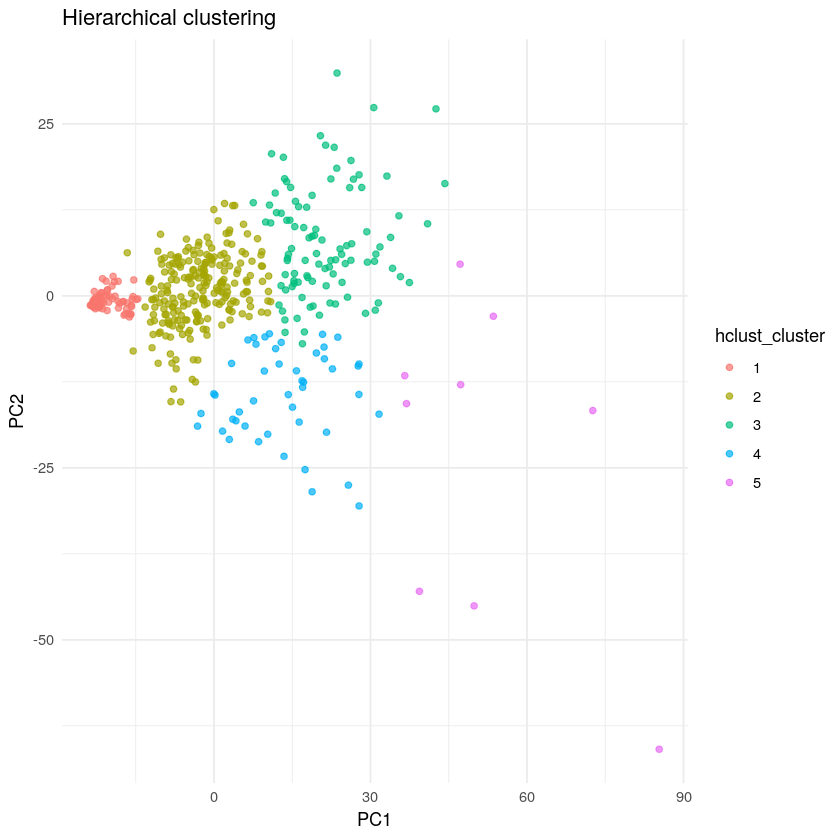

In [2]:
library(Matrix)
library(stats)
library(ggplot2)

# === Load matrix and metadata ===
matrix_file <- "/sharedFolder/Data/matrix.mtx.gz"
features_file <- "/sharedFolder/Data/features.tsv.gz"
barcodes_file <- "/sharedFolder/Data/barcodes.tsv.gz"

mat <- readMM(matrix_file)
genes <- readLines(features_file)
barcodes <- readLines(barcodes_file)

# Apply row and column names
rownames(mat) <- genes
colnames(mat) <- barcodes

cat("✅ Loaded matrix: ", nrow(mat), " genes x ", ncol(mat), " cells\n")

# === Subsample 500 cells ===
set.seed(42)
selected_cells <- sample(colnames(mat), 500)
mat_sub <- mat[, selected_cells]

# === Select top 1000 most variable genes ===
gene_vars <- apply(mat_sub, 1, var)
top_genes <- names(sort(gene_vars, decreasing = TRUE))[1:1000]
mat_filtered <- mat_sub[top_genes, ]

# === PCA on transposed matrix (cells × genes) ===
mat_dense <- as.matrix(t(mat_filtered))
mat_scaled <- scale(mat_dense)
pca_res <- prcomp(mat_scaled, rank. = 10)
pca_df <- as.data.frame(pca_res$x[, 1:2])
pca_df$cell <- rownames(pca_df)

# === K-means clustering ===
set.seed(42)
k <- 5
kres <- kmeans(pca_df[, 1:2], centers = k)
pca_df$kmeans_cluster <- factor(kres$cluster)

# === Hierarchical clustering ===
d <- dist(pca_df[, 1:2])
hc <- hclust(d, method = "ward.D2")
pca_df$hclust_cluster <- factor(cutree(hc, k = k))

# === Plotting ===
p1 <- ggplot(pca_df, aes(PC1, PC2, color = kmeans_cluster)) +
  geom_point(alpha = 0.7) + theme_minimal() + ggtitle("K-means clustering")

p2 <- ggplot(pca_df, aes(PC1, PC2, color = hclust_cluster)) +
  geom_point(alpha = 0.7) + theme_minimal() + ggtitle("Hierarchical clustering")

print(p1)
print(p2)


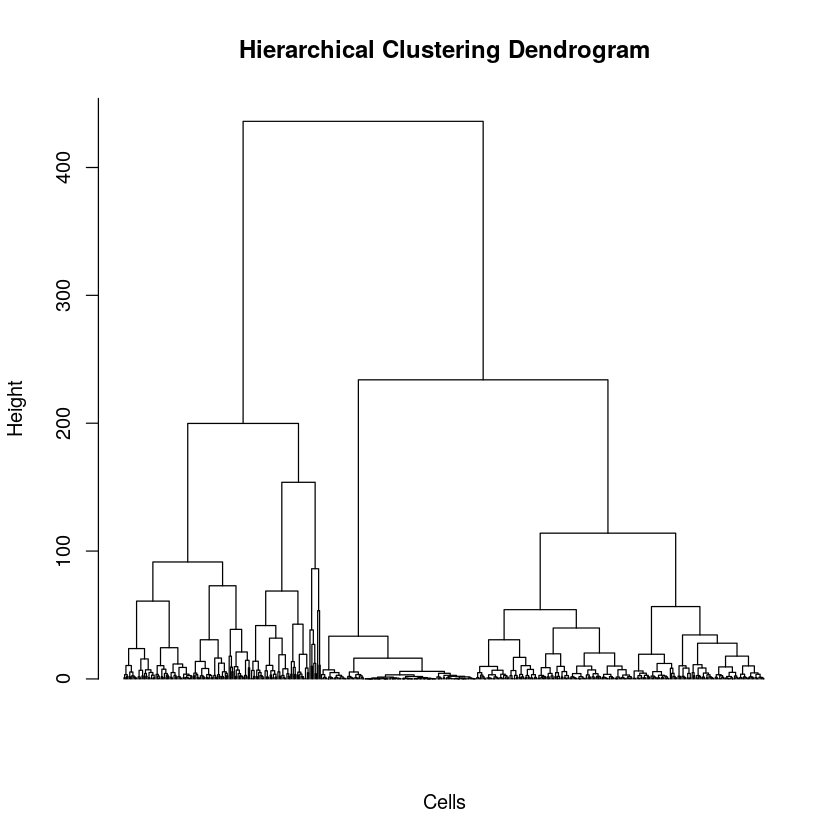

In [3]:
# Plot dendrogram with white background and black lines
par(bg = "white", fg = "black", col.lab = "black", col.main = "black", col.axis = "black", mar = c(5, 4, 4, 2) + 0.1)

plot(hc,
     labels = FALSE,
     main = "Hierarchical Clustering Dendrogram",
     xlab = "Cells",
     sub = "",
     hang = -1,
     col = "black")  # force line color
